In [16]:
import logging

logger = logging.getLogger()
logger.disabled = True

import os
from collections import Counter
from copy import deepcopy

from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from agent import DQNAgent
from humemai.utils import read_yaml
from agent.policy import (
    answer_question,
    argmax,
    encode_observation,
    explore,
    manage_memory,
)


def process_room_observations(
    agent: DQNAgent, observations_room: list
) -> tuple[list, list, list, list]:
    """Process room observations. This is used when training an exploration policy.

    Args:
        DQNAgent: agent
        observations_room: observations["room"] from the environment

    Returns:
        tuple[list, list, list]: states_all, attention_all, q_values_all, actions_all

    """
    states_all = []
    attention_all = []
    q_values_all = []
    actions_all = []

    for obs in observations_room:
        encode_observation(agent.memory_systems, obs)
        state = agent.memory_systems.return_as_a_dict_list()
        states_all.append(deepcopy(state))
        with torch.no_grad():
            lstm_out, attention = agent.lstm_mm(
                np.array([state]), agent.memory_types["mm"]
            )
            attention = attention.squeeze(0).sum(dim=0).tolist()
            q_values = agent.mlp_mm(lstm_out).detach().cpu().tolist()[0]

            action = argmax(q_values)

            manage_memory(
                memory_systems=agent.memory_systems,
                policy=agent.action2str["mm"][action],
                split_possessive=False,
            )

        attention_all.append(deepcopy(attention))
        q_values_all.append(deepcopy(q_values))
        actions_all.append(deepcopy(action))
    agent.memory_systems.semantic.decay()

    return states_all, attention_all, q_values_all, actions_all


def explore(agent: DQNAgent) -> tuple[list, list, list, list]:
    """Explore the environment using the exploration policy.

    Args:
        DQNAgent: agent

    Returns:
        tuple[dict, list, list]: state, attention, q_values, action

    """
    state = agent.get_deepcopied_memory_state()
    with torch.no_grad():
        lstm_out, attention = agent.lstm_explore(
            np.array([state]), agent.memory_types["explore"]
        )
        attention = attention.squeeze(0).sum(dim=0).tolist()
        q_values = agent.mlp_explore(lstm_out).detach().cpu().tolist()[0]
        action = argmax(q_values)

    return state, attention, q_values, action


def load_models(agent: DQNAgent, root_path: str) -> None:
    """Load models from a given root_path.

    Args:
        DQNAgent: agent
        root_path: root path

    """
    for checkpoint_path in glob(os.path.join(root_path, "*/*/*/*.pt")):
        if "mm" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_mm.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_mm.eval()
            for param in agent.lstm_mm.parameters():
                param.requires_grad = False
        elif "mm" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_mm.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_mm.eval()
            for param in agent.mlp_mm.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_explore.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_explore.eval()
            for param in agent.lstm_explore.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_explore.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_explore.eval()
            for param in agent.mlp_explore.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unknown checkpoint path")


# 2024-07-03 11:04:45.642487 0.7
# 5 :  218 	 Counter({0: 343, 2: 301, 1: 145}) Counter({1: 90, 3: 9, 2: 1})

# 2024-07-03 13:06:14.393364 0.7
# 0 :  273 	 Counter({1: 369, 2: 140, 0: 14}) Counter({2: 55, 1: 45})
# 6 :  371 	 Counter({1: 397, 2: 150, 0: 14}) Counter({2: 67, 1: 33})

for path in ["2024-08-04 17:00:52.744168"]:
    root_path = f"training-results/equal-object-probs/dqn/room_size=m/capacity=12/{path}/"
    for semantic_decay_factor in [0.8]:
        train_params_path = os.path.join(root_path, "train.yaml")
        train_params = read_yaml(train_params_path)
        train_params["default_root_dir"] = "training-results/TRASH"
        train_params["semantic_decay_factor"] = semantic_decay_factor
        num_tests = 20

        stats_interest = [
            {
                "mm": {"state": [], "attention": [], "q_value": [], "action": []},
                "explore": {"state": [], "attention": [], "q_value": [], "action": []},
                "questions": [],
                "answers": [],
                "score": None,
            }
            for _ in range(num_tests)
        ]

        for idx in tqdm(range(num_tests)):
            train_params["train_seed"] = idx
            train_params["test_seed"] = idx
            agent = DQNAgent(**train_params)
            load_models(agent, root_path)
            new_episode_starts = True
            score = 0
            while True:
                if new_episode_starts:
                    agent.init_memory_systems()
                    observations, info = agent.env.reset()
                    done = False
                    states_all, attention_all, q_values_all, actions_all = (
                        process_room_observations(agent, observations["room"])
                    )
                    stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
                    stats_interest[idx]["mm"]["attention"].extend(
                        deepcopy(attention_all)
                    )
                    stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
                    stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

                    new_episode_starts = False

                else:
                    state, attention, q_values, action = explore(agent)
                    stats_interest[idx]["explore"]["state"].append(deepcopy(state))
                    stats_interest[idx]["explore"]["attention"].append(
                        deepcopy(attention)
                    )
                    stats_interest[idx]["explore"]["q_value"].append(deepcopy(q_values))
                    stats_interest[idx]["explore"]["action"].append(deepcopy(action))

                    answers = [
                        answer_question(
                            agent.memory_systems,
                            agent.qa_function,
                            q,
                            split_possessive=False,
                        )
                        for q in observations["questions"]
                    ]
                    stats_interest[idx]["questions"].extend(
                        deepcopy(observations["questions"])
                    )
                    stats_interest[idx]["answers"].extend(deepcopy(answers))

                    action_pair = (answers, agent.action2str["explore"][action])
                    (
                        observations,
                        reward,
                        done,
                        truncated,
                        info,
                    ) = agent.env.step(action_pair)
                    done = done or truncated

                    if not done:
                        states_all, attention_all, q_values_all, actions_all = (
                            process_room_observations(agent, observations["room"])
                        )
                        stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
                        stats_interest[idx]["mm"]["attention"].extend(
                            deepcopy(attention_all)
                        )
                        stats_interest[idx]["mm"]["q_value"].extend(
                            deepcopy(q_values_all)
                        )
                        stats_interest[idx]["mm"]["action"].extend(
                            deepcopy(actions_all)
                        )

                    score += reward

                if done:
                    break
            stats_interest[idx]["score"] = score

            agent.remove_results_from_disk()

        from collections import Counter

        print(path, semantic_decay_factor)
        for idx in range(num_tests):
            print(
                idx,
                ": ",
                stats_interest[idx]["score"],
                "\t",
                Counter(stats_interest[idx]["mm"]["action"]),
                Counter(stats_interest[idx]["explore"]["action"]),
            )

  0%|          | 0/20 [00:00<?, ?it/s]/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/hom

Running on cpu


  5%|▌         | 1/20 [00:01<00:19,  1.03s/it]

Running on cpu


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

Running on cpu


 15%|█▌        | 3/20 [00:03<00:18,  1.07s/it]

Running on cpu


 20%|██        | 4/20 [00:04<00:16,  1.03s/it]

Running on cpu


 25%|██▌       | 5/20 [00:05<00:15,  1.05s/it]

Running on cpu


 30%|███       | 6/20 [00:06<00:14,  1.05s/it]

Running on cpu


 35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]

Running on cpu


 40%|████      | 8/20 [00:08<00:14,  1.18s/it]

Running on cpu


 45%|████▌     | 9/20 [00:09<00:12,  1.11s/it]

Running on cpu


 50%|█████     | 10/20 [00:10<00:10,  1.10s/it]

Running on cpu


 55%|█████▌    | 11/20 [00:12<00:10,  1.19s/it]

Running on cpu


 60%|██████    | 12/20 [00:13<00:09,  1.19s/it]

Running on cpu


 65%|██████▌   | 13/20 [00:14<00:07,  1.12s/it]

Running on cpu


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

Running on cpu


 75%|███████▌  | 15/20 [00:16<00:05,  1.11s/it]

Running on cpu


 80%|████████  | 16/20 [00:17<00:04,  1.05s/it]

Running on cpu


 85%|████████▌ | 17/20 [00:18<00:03,  1.10s/it]

Running on cpu


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

Running on cpu


 95%|█████████▌| 19/20 [00:20<00:01,  1.03s/it]

Running on cpu


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

2024-08-04 17:00:52.744168 0.8
0 :  738 	 Counter({0: 475, 1: 53, 2: 32}) Counter({1: 69, 2: 16, 0: 15})
1 :  687 	 Counter({0: 481, 1: 65, 2: 32}) Counter({3: 36, 2: 29, 0: 28, 1: 7})
2 :  596 	 Counter({0: 511, 2: 54, 1: 43}) Counter({2: 49, 0: 47, 1: 4})
3 :  533 	 Counter({0: 478, 1: 82, 2: 38}) Counter({2: 31, 0: 30, 3: 27, 1: 10, 4: 2})
4 :  634 	 Counter({0: 473, 1: 122, 2: 30}) Counter({2: 42, 0: 40, 3: 11, 1: 7})
5 :  585 	 Counter({0: 496, 2: 39, 1: 39}) Counter({0: 44, 2: 38, 4: 12, 1: 6})
6 :  479 	 Counter({0: 484, 1: 98, 2: 27}) Counter({2: 36, 0: 34, 1: 28, 3: 2})
7 :  778 	 Counter({0: 472, 1: 130, 2: 30}) Counter({2: 48, 0: 46, 1: 5, 3: 1})
8 :  400 	 Counter({0: 504, 2: 51, 1: 50}) Counter({3: 39, 2: 24, 0: 22, 1: 15})
9 :  590 	 Counter({0: 480, 1: 98, 2: 31}) Counter({2: 48, 0: 46, 1: 6})
10 :  707 	 Counter({0: 478, 1: 115, 2: 38}) Counter({2: 48, 0: 46, 1: 5, 3: 1})
11 :  684 	 Counter({0: 507, 1: 149, 2: 32}) Counter({2: 46, 0: 45, 1: 7, 3: 2})
12 :  593 	 Counte

In [83]:
from humemai.utils import write_json

In [84]:
write_json(stats_interest[idx_of_interest], "stats_of_interest.json")

In [17]:
idx_of_interest = 7

In [18]:
[(idx, foo) for idx, foo in enumerate(agent.env.hidden_global_states_all)]

/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.hidden_global_states_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.hidden_global_states_all` for environment variables or `env.get_wrapper_attr('hidden_global_states_all')` that will search the reminding wrappers.
  logger.warn(


[(0,
  [['room_000', 'north', 'wall', 0],
   ['room_000', 'east', 'room_001', 0],
   ['room_000', 'south', 'wall', 0],
   ['room_000', 'west', 'wall', 0],
   ['room_001', 'north', 'wall', 0],
   ['room_001', 'east', 'room_002', 0],
   ['room_001', 'south', 'wall', 0],
   ['room_001', 'west', 'room_000', 0],
   ['room_002', 'north', 'wall', 0],
   ['room_002', 'east', 'wall', 0],
   ['room_002', 'south', 'room_003', 0],
   ['room_002', 'west', 'room_001', 0],
   ['room_003', 'north', 'room_002', 0],
   ['room_003', 'east', 'wall', 0],
   ['room_003', 'south', 'room_004', 0],
   ['room_003', 'west', 'wall', 0],
   ['room_004', 'north', 'room_003', 0],
   ['room_004', 'east', 'wall', 0],
   ['room_004', 'south', 'room_005', 0],
   ['room_004', 'west', 'wall', 0],
   ['room_005', 'north', 'room_004', 0],
   ['room_005', 'east', 'wall', 0],
   ['room_005', 'south', 'room_007', 0],
   ['room_005', 'west', 'wall', 0],
   ['room_006', 'north', 'wall', 0],
   ['room_006', 'east', 'room_007', 0]

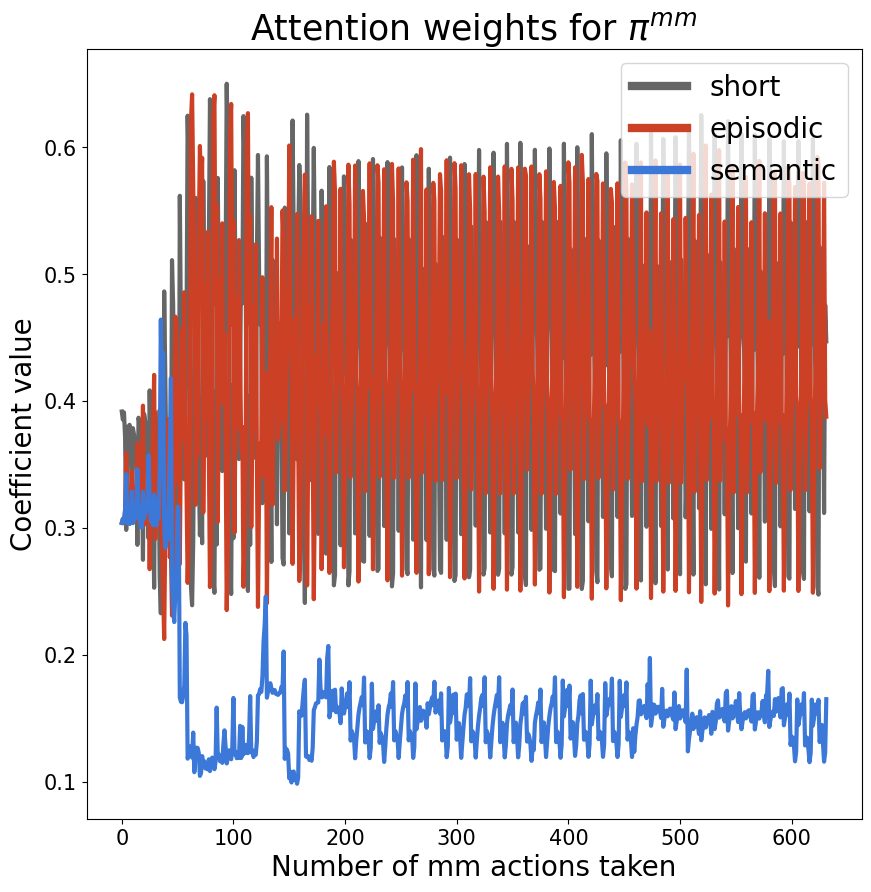

In [19]:
colors = ["#666666ff", "#cc4125ff", "#3c78d8ff"]  # short, episodic, semantic

plt.figure(figsize=(10, 10))
for i in range(len(agent.memory_types["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["attention"]],
        label=agent.memory_types["mm"][i],
        color=colors[i],
        linewidth=3.0,
    )

# Create the legend
leg = plt.legend(loc="upper right", fontsize=20)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{mm}$", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("attention_weights_mm.pdf")
plt.show()

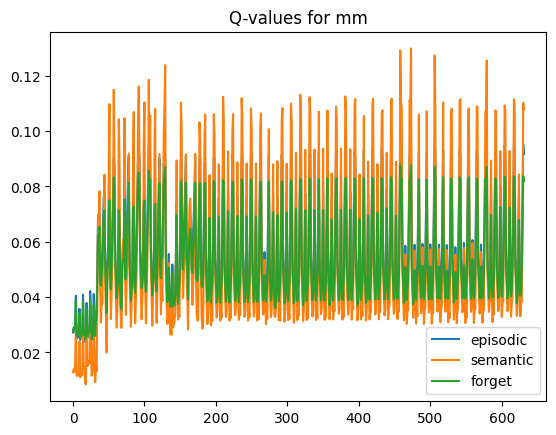

In [20]:
for i in range(len(agent.action2str["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["q_value"]],
        label=agent.action2str["mm"][i],
    )

plt.legend(loc="lower right")
plt.title("Q-values for mm");

In [21]:
[
    (idx, agent.action2str["mm"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["action"])
]

[(0, 'forget'),
 (1, 'forget'),
 (2, 'forget'),
 (3, 'episodic'),
 (4, 'episodic'),
 (5, 'forget'),
 (6, 'forget'),
 (7, 'forget'),
 (8, 'forget'),
 (9, 'episodic'),
 (10, 'forget'),
 (11, 'forget'),
 (12, 'forget'),
 (13, 'forget'),
 (14, 'episodic'),
 (15, 'forget'),
 (16, 'episodic'),
 (17, 'forget'),
 (18, 'forget'),
 (19, 'episodic'),
 (20, 'forget'),
 (21, 'forget'),
 (22, 'forget'),
 (23, 'forget'),
 (24, 'episodic'),
 (25, 'episodic'),
 (26, 'forget'),
 (27, 'episodic'),
 (28, 'episodic'),
 (29, 'episodic'),
 (30, 'episodic'),
 (31, 'forget'),
 (32, 'episodic'),
 (33, 'episodic'),
 (34, 'episodic'),
 (35, 'semantic'),
 (36, 'episodic'),
 (37, 'semantic'),
 (38, 'episodic'),
 (39, 'episodic'),
 (40, 'episodic'),
 (41, 'episodic'),
 (42, 'episodic'),
 (43, 'episodic'),
 (44, 'semantic'),
 (45, 'episodic'),
 (46, 'episodic'),
 (47, 'forget'),
 (48, 'episodic'),
 (49, 'episodic'),
 (50, 'semantic'),
 (51, 'semantic'),
 (52, 'episodic'),
 (53, 'episodic'),
 (54, 'episodic'),
 (55, '

In [22]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["state"])
]

[(0,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'north', 'wall', 0]]}),
 (1,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'east', 'room_001', 0]]}),
 (2,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'south', 'wall', 0]]}),
 (3,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'west', 'wall', 0]]}),
 (4,
  1,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0]],
   'semantic': [],
   'short': [['agent', 'atlocation', 'room_000', 0]]}),
 (5,
  2,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0]],
   'semantic': [],
   'short': [['room_001', 'north', 'wall', 1]]}),
 (6,
  2,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0]],
   'semantic': [],
   'short': [['room_001', 'east', 'room_002', 1]]}),
 (7,
  2,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocati

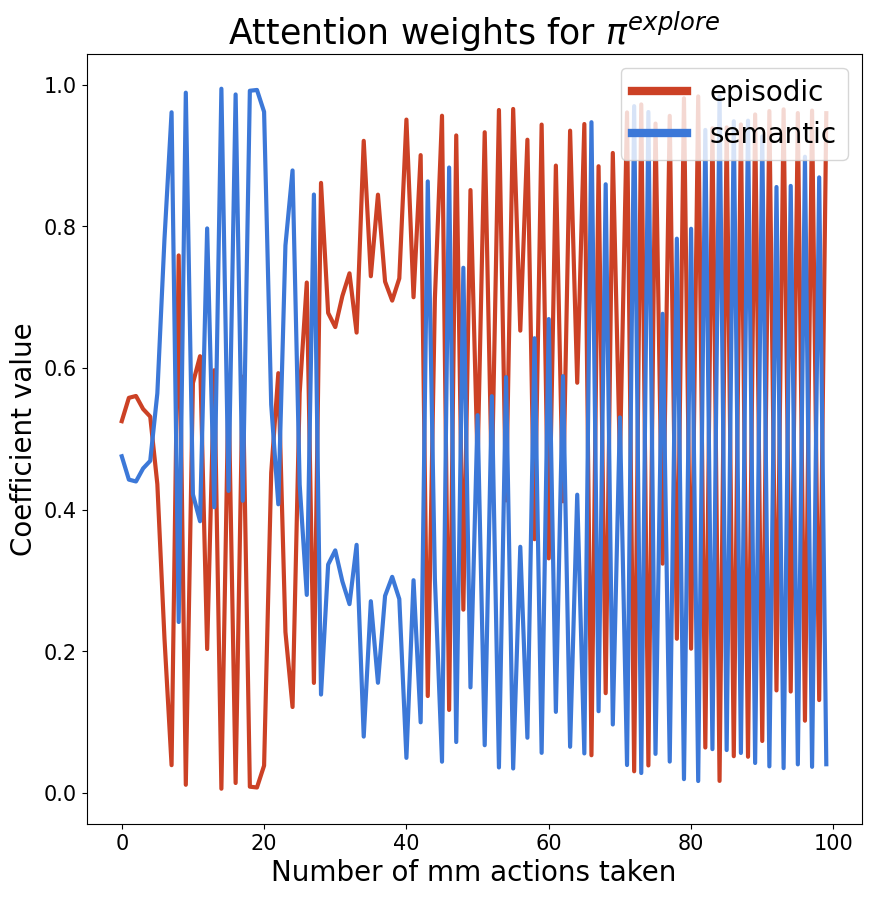

In [23]:
colors = ["#cc4125ff", "#3c78d8ff"]  # short, episodic, semantic

plt.figure(figsize=(10, 10))

for i in range(len(agent.memory_types["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["attention"]],
        label=agent.memory_types["explore"][i],
        linewidth=3.0,
        color=colors[i],
    )

# Create the legend
leg = plt.legend(loc="upper right", fontsize=20)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{explore}$", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("attention_weights_explore.pdf")
plt.show()

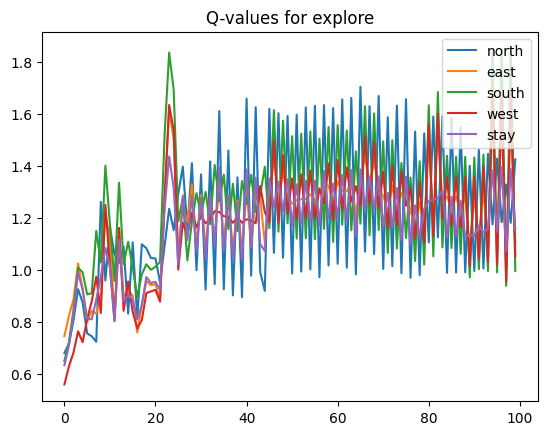

In [24]:
for i in range(len(agent.action2str["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["q_value"]],
        label=agent.action2str["explore"][i],
    )

plt.legend(loc="upper right")
plt.title("Q-values for explore");

In [25]:
[
    (idx, agent.action2str["explore"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["action"])
]

[(0, 'east'),
 (1, 'east'),
 (2, 'east'),
 (3, 'east'),
 (4, 'south'),
 (5, 'south'),
 (6, 'south'),
 (7, 'south'),
 (8, 'north'),
 (9, 'south'),
 (10, 'south'),
 (11, 'north'),
 (12, 'south'),
 (13, 'north'),
 (14, 'south'),
 (15, 'north'),
 (16, 'south'),
 (17, 'north'),
 (18, 'north'),
 (19, 'north'),
 (20, 'north'),
 (21, 'south'),
 (22, 'south'),
 (23, 'south'),
 (24, 'south'),
 (25, 'north'),
 (26, 'north'),
 (27, 'east'),
 (28, 'north'),
 (29, 'south'),
 (30, 'north'),
 (31, 'south'),
 (32, 'north'),
 (33, 'south'),
 (34, 'north'),
 (35, 'south'),
 (36, 'north'),
 (37, 'south'),
 (38, 'north'),
 (39, 'south'),
 (40, 'north'),
 (41, 'south'),
 (42, 'north'),
 (43, 'west'),
 (44, 'south'),
 (45, 'north'),
 (46, 'south'),
 (47, 'north'),
 (48, 'south'),
 (49, 'north'),
 (50, 'south'),
 (51, 'north'),
 (52, 'south'),
 (53, 'north'),
 (54, 'south'),
 (55, 'north'),
 (56, 'south'),
 (57, 'north'),
 (58, 'south'),
 (59, 'north'),
 (60, 'south'),
 (61, 'north'),
 (62, 'south'),
 (63, 'n

In [26]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["state"])
]

[(0,
  2,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0]],
   'semantic': [],
   'short': []}),
 (1,
  3,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['agent', 'atlocation', 'room_001', 1]],
   'semantic': [],
   'short': []}),
 (2,
  4,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['agent', 'atlocation', 'room_001', 1],
    ['agent', 'atlocation', 'room_002', 2]],
   'semantic': [],
   'short': []}),
 (3,
  6,
  0,
  {'episodic': [['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['agent', 'atlocation', 'room_001', 1],
    ['agent', 'atlocation', 'room_002', 2],
    ['room_002', 'east', 'wall', 3],
    ['agent', 'atlocation', 'room_002', 3]],
   'semantic': [],
   'short': []}),
 (4,
  6,
  0,
  {'episodic': [['agent', 'atlocation', 'room_000', 0],
    ['agent', 'atlocation', 'room_001', 1],


In [27]:
Counter([str(foo[:-1]) for foo in stats_interest[idx_of_interest]["questions"]])

Counter({"['sta_000', 'atlocation', '?']": 173,
         "['ind_001', 'atlocation', '?']": 171,
         "['ind_000', 'atlocation', '?']": 170,
         "['dep_001', 'atlocation', '?']": 166,
         "['dep_000', 'atlocation', '?']": 161,
         "['sta_001', 'atlocation', '?']": 159})

In [28]:
from collections import Counter

Counter([str(foo) for foo in stats_interest[idx_of_interest]["answers"]])

Counter({'room_004': 313,
         'room_005': 217,
         'room_007': 200,
         'none': 156,
         'room_003': 114})